In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Считывание

In [2]:
link = 'https://docs.google.com/spreadsheets/d/1ed1JHrNJEYWJcn-3KiB3CjWzO8E5qHQd-MHM8qQO7a4/edit?usp=sharing'
id = link.split('/')[-2]
file_path = f'https://docs.google.com/spreadsheets/d/{id}/export?format=xlsx'
# Создаем объект ExcelFile, который предоставляет информацию о вкладках в файле
excel_file = pd.ExcelFile(file_path)
# Получаем список имен вкладок (листов) в файле
sheet_names = excel_file.sheet_names

In [3]:
sheet_names

['Каталог', 'Продажи', 'Себестоимость']

In [4]:
catalog = pd.read_excel(file_path, sheet_name='Каталог')
sell = pd.read_excel(file_path, sheet_name='Продажи')
production_cost = pd.read_excel(file_path, sheet_name='Себестоимость')

In [5]:
catalog.head()

,Артикул 1C,SKU,Название,Статус,МП
0,1111,1234,Телефон,Продвигаем,Wildberries
1,2222,5678,Сумка серая,Сливаем,Wildberries
2,3333,9101,Картина,Сливаем,Wildberries
3,4444,1213,Соус Ворчестер,Продвигаем,Wildberries
4,1111,43434,Телефон,Продвигаем,Ozon


In [6]:
sell.head()

,Артикул 1C,SKU,"Цена продажи,р",Кол-во,Комиссия(% от выручки),"Логистика,р",Дата
0,1111,1234,414,2,10,5,2022-01-01
1,2222,5678,243,1,10,5,2022-01-07
2,3333,9101,423,2,10,5,2022-01-13
3,4444,1213,325,3,10,5,2022-01-19
4,1111,1234,414,4,10,5,2022-01-25


In [7]:
production_cost.head()

,Артикул 1C,Себестоимость
0,1111,186.30
1,2222,109.35
2,3333,190.35
3,4444,146.25


### Вычислить ВП:
ВП = Выручка − себестоимость − комиссия − логистика\
Выручка = цена * кол-во продаж

In [8]:
# Общая таблица
all_info = (
    catalog
    .merge(sell, on=['Артикул 1C', 'SKU'], how='right')
    .merge(production_cost, on='Артикул 1C', how='inner')
    .sort_values('Дата')
)
all_info.head()

,Артикул 1C,SKU,Название,Статус,МП,"Цена продажи,р",Кол-во,Комиссия(% от выручки),"Логистика,р",Дата,Себестоимость
0,1111,1234,Телефон,Продвигаем,Wildberries,414,2,10,5,2022-01-01,186.30
31,2222,5678,Сумка серая,Сливаем,Wildberries,243,1,10,5,2022-01-01,109.35
62,3333,9101,Картина,Сливаем,Wildberries,423,2,10,5,2022-01-01,190.35
93,4444,45214,Соус Ворчестер,Продвигаем,Ozon,398,1,8,10,2022-01-01,146.25
18,1111,1234,Телефон,Продвигаем,Wildberries,414,6,10,5,2022-01-01,186.30


In [9]:
all_info.dtypes

Артикул 1C                         int64
SKU                                int64
Название                          object
Статус                            object
МП                                object
Цена продажи,р                     int64
Кол-во                             int64
Комиссия(% от выручки)             int64
Логистика,р                        int64
Дата                      datetime64[ns]
Себестоимость                    float64
dtype: object

In [10]:
all_info.shape[0]

107

In [11]:
sell.shape[0]

107

In [12]:
# ВП
all_info['ВП'] = (
    all_info['Цена продажи,р'].mul(all_info['Кол-во'])
    .subtract(all_info['Цена продажи,р'].mul(all_info['Кол-во']).div(100).mul(all_info['Комиссия(% от выручки)']))
    .subtract(all_info['Себестоимость'])
    .subtract(all_info['Логистика,р'])
)

In [13]:
all_info.head()

,Артикул 1C,SKU,Название,Статус,МП,"Цена продажи,р",Кол-во,Комиссия(% от выручки),"Логистика,р",Дата,Себестоимость,ВП
0,1111,1234,Телефон,Продвигаем,Wildberries,414,2,10,5,2022-01-01,186.30,553.90
31,2222,5678,Сумка серая,Сливаем,Wildberries,243,1,10,5,2022-01-01,109.35,104.35
62,3333,9101,Картина,Сливаем,Wildberries,423,2,10,5,2022-01-01,190.35,566.05
93,4444,45214,Соус Ворчестер,Продвигаем,Ozon,398,1,8,10,2022-01-01,146.25,209.91
18,1111,1234,Телефон,Продвигаем,Wildberries,414,6,10,5,2022-01-01,186.30,2044.30


### Визуализировать ВП «time-frame» неделя. Пример на рисунке 1.


In [14]:
df = all_info[['Дата', 'ВП']]
# выводим номер недели (номер для первой недели января некорректный, потому делаю такую штуку)
df['week_num'] = df['Дата'].dt.week.apply(lambda x: 1 if x == 52 else x + 1)
# год
df['year'] = df['Дата'].dt.year
# текст
df['week_year'] = df.week_num.astype(str) + 'Нед' + ' ' + df.year.astype(str) + 'г'

/var/folders/4f/p3vpw9ps3593s5s2jk3p3ftm0000gn/T/ipykernel_29990/1039364916.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_num'] = df['Дата'].dt.week.apply(lambda x: 1 if x == 52 else x + 1)
/var/folders/4f/p3vpw9ps3593s5s2jk3p3ftm0000gn/T/ipykernel_29990/1039364916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_num'] = df['Дата'].dt.week.apply(lambda x: 1 if x == 52 else x + 1)
/var/folders/4f/p3vpw9ps3593s5s2jk3p3ftm0000gn/T/ipykernel_29990/1039364916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [15]:
chart = (
    df
    .groupby(['Дата', 'week_year'], as_index=False)
    .agg({'ВП': 'sum'})
)

In [16]:
# Установка настройки графика по умолчанию
sns.set(
    font_scale=2, # размер шрифта
    style='whitegrid', # вид графика
    rc={'figure.figsize':(20, 8)}) # размер графика

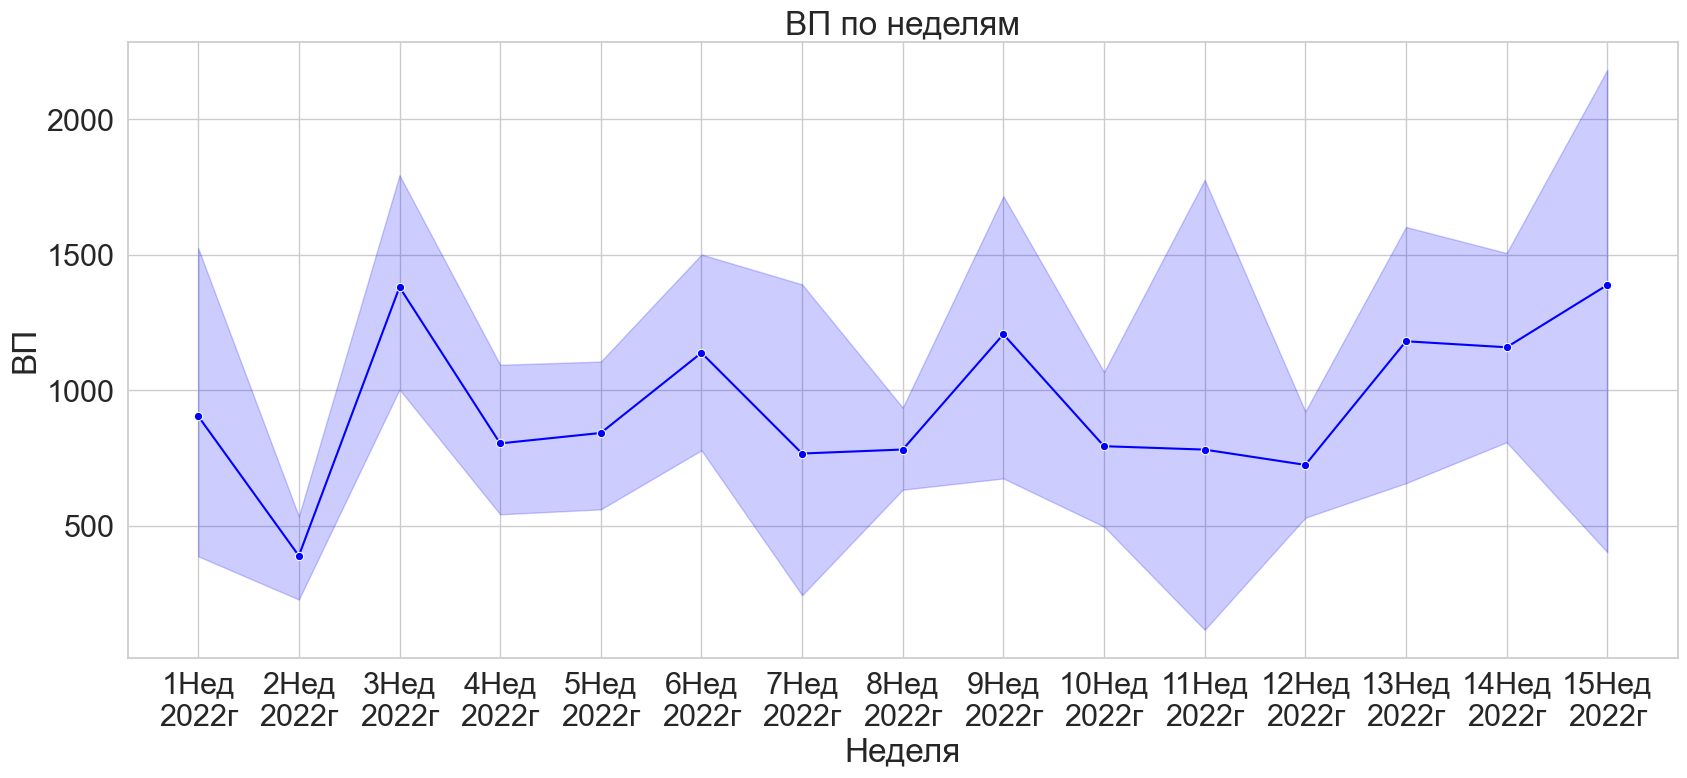

In [17]:
sns.lineplot(x=df['week_year'].str.replace(' ', '\n'), y='ВП', data=df, color='blue', marker='o')
plt.xlabel('Неделя')
plt.ylabel('ВП')
plt.title('ВП по неделям');

In [25]:
chart['rol'] = chart['ВП'].rolling(window=5).mean()

In [26]:
chart

,Дата,week_year,ВП,rol
0,2022-01-01,1Нед 2022г,6331.54,NaN
1,2022-01-04,2Нед 2022г,245.60,NaN
2,2022-01-07,2Нед 2022г,3255.39,NaN
3,2022-01-10,3Нед 2022г,2801.60,NaN
4,2022-01-13,3Нед 2022г,9584.93,4443.812
5,2022-01-16,3Нед 2022г,2804.30,3738.364
6,2022-01-19,4Нед 2022г,6041.87,4897.618
7,2022-01-22,4Нед 2022г,1194.20,4485.380
8,2022-01-25,5Нед 2022г,5546.38,5034.336
9,2022-01-28,5Нед 2022г,1194.20,3356.190


<AxesSubplot:xlabel='Дата', ylabel='ВП'>

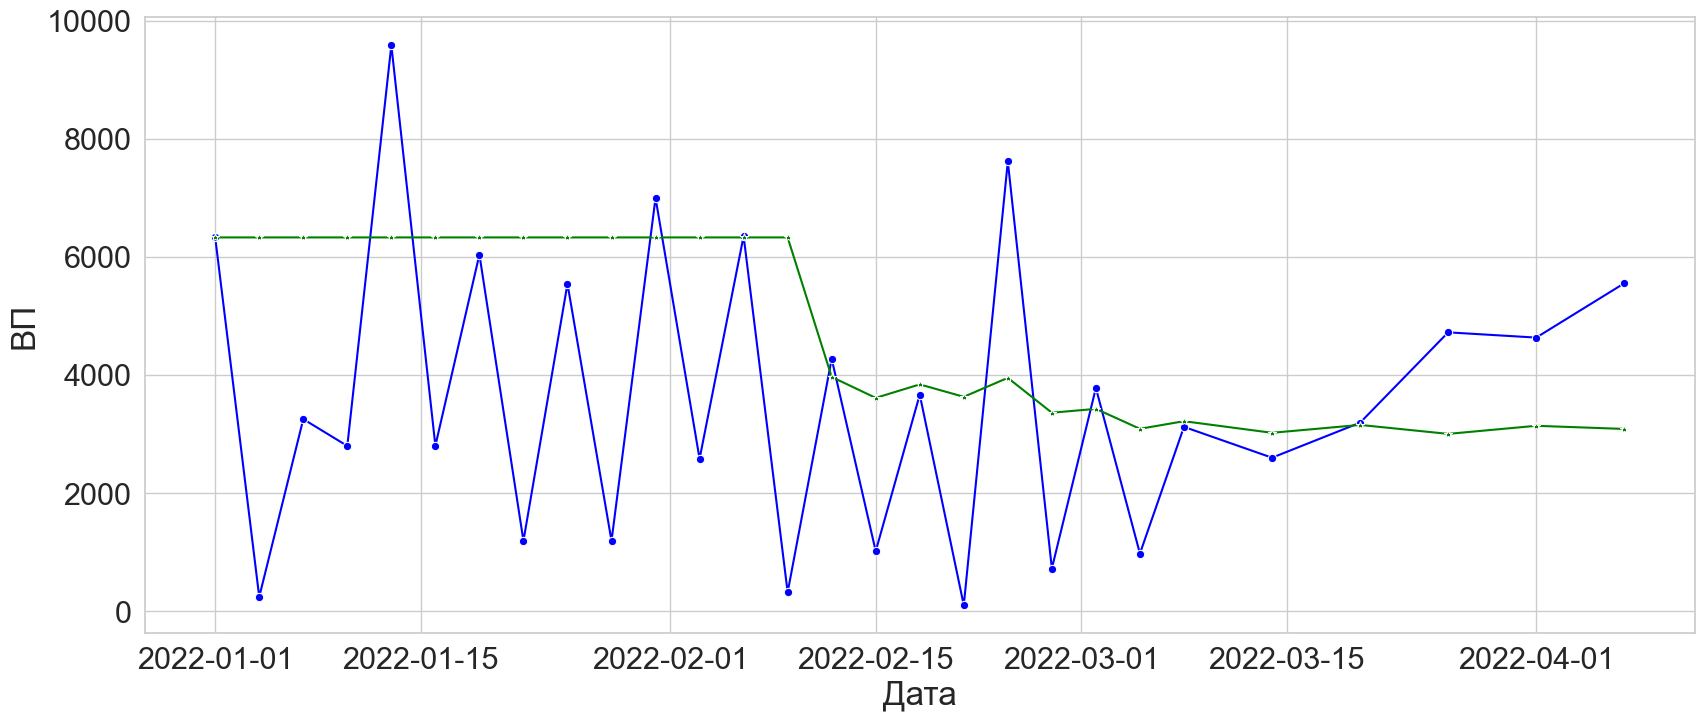

In [20]:
sns.lineplot(x='Дата', y='ВП', data=chart, color='blue', marker='o')
sns.lineplot(x='Дата', y='rol', data=chart, color='green', marker='*')